In [1]:
library(tidyverse)
library(data.table)
library(pROC)


── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.2.1     ✔ purrr   0.3.2
✔ tibble  2.1.3     ✔ dplyr   0.8.3
✔ tidyr   0.8.3     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘data.table’

The following objects are masked from ‘package:dplyr’:

    between, first, last

The following object is masked from ‘package:purrr’:

    transpose

Type 'citation("pROC")' for a citation.

Attaching package: ‘pROC’

The following objects are masked from ‘package:stats’:

    cov, smooth, var



In [2]:
source('helper_funcs.R')

In [3]:
split_df <- bind_rows(lapply(c('train', 'val', 'test'), function(split){
fread(
file.path('/scratch/users/ytanigaw/tmp/snpnet/geno/array_combined', paste0(split, '.fam')),
colClasses="character"
) %>%
select(V1, V2) %>%
rename(FID = V1, IID = V2) %>%
mutate(split = split)
}))


In [4]:
prj_dir <- '/oak/stanford/groups/mrivas/users/ytanigaw/repos/rivas-lab/PRS/jobs/hearing_2247'


In [5]:
phe_file <- file.path(prj_dir, 'phe.tsv')


In [6]:
phe_df <- fread(phe_file)

## BIN_FC1002247

In [10]:
GBE_ID <- 'BIN_FC1002247'
prevIter <- 9
phe_label <- 'Hearing difficulty'

In [11]:
covar_beta_file <- 
get_rdata_path(GBE_ID, prevIter) %>%
str_replace('.RData$', '.covars.tsv')

geno_score_file <-
file.path(prj_dir, GBE_ID, 'results', 'score', paste0(GBE_ID, '.sscore'))


In [12]:
score_df <- compute_score(phe_df, covar_beta_file, geno_score_file)

all_df <- score_df %>% 
inner_join(split_df, by=c('FID', 'IID')) %>%
inner_join(
phe_df %>% rename('phe' = GBE_ID) %>% select(FID, IID, phe) %>%
mutate(FID = as.character(FID), IID = as.character(IID)), 
by=c('FID', 'IID'))


[1] "geno_score"


Setting levels: control = 1, case = 2
Setting direction: controls < cases


Area under the curve: 0.5364
[1] "covar_score"


Setting levels: control = 1, case = 2
Setting direction: controls < cases


Area under the curve: 0.6177
[1] "score"


Setting levels: control = 1, case = 2
Setting direction: controls < cases


Area under the curve: 0.6234


Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image


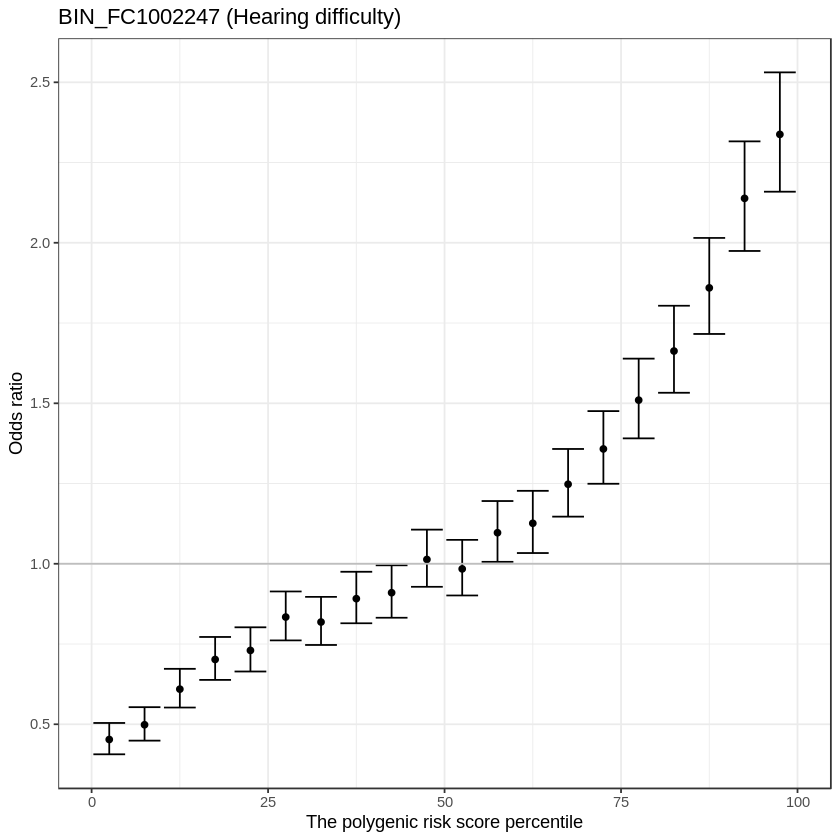

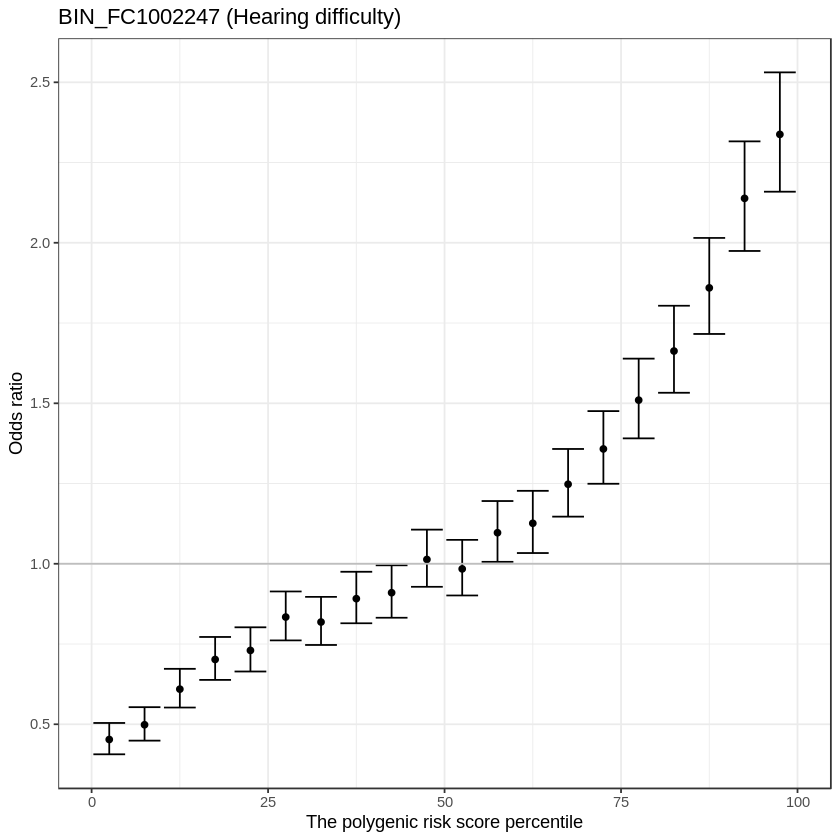

In [16]:
for(score in c('geno_score', 'covar_score', 'score')){
    print(score)
    compute_auc(all_df, 'test', score) %>% print()
}

OR_tbl <- all_df %>% compute_OR_tbl('test', 'score')

p <- OR_tbl %>%
filter(u_bin != 0.001, u_bin != 0.01, l_bin != 0.99, l_bin != 0.999) %>%
mutate(bin = 100 * (1 - 0.5 * (u_bin + l_bin))) %>%
ggplot(aes(x=bin, y=OR)) +
geom_point() + 
geom_errorbar(aes(ymin = l_OR, ymax = u_OR)) + 
geom_hline(yintercept = 1, color='gray')+
theme_bw() + 
labs(
    title = sprintf('%s (%s)', GBE_ID, phe_label),
    x = 'The polygenic risk score percentile',
    y = 'Odds ratio'
)

OR_tbl %>% fwrite(paste0(GBE_ID, '.OR.tsv'), sep='\t')

p + ggsave(paste0(GBE_ID, '.OR.pdf'))
p + ggsave(paste0(GBE_ID, '.OR.png'))


In [17]:
OR_tbl

l_bin,u_bin,n_TP,n_FN,n_FP,n_TN,OR,SE_LOR,l_OR,u_OR,OR_str
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
0.000,0.050,1464,3363,1792,9623,2.3376888,0.04052613,2.1591865,2.5309480,2.338 (2.159-2.531)
0.050,0.100,1393,3363,1864,9623,2.1383994,0.04068940,1.9744826,2.3159242,2.138 (1.974-2.316)
0.100,0.150,1290,3363,1985,9623,1.8595712,0.04099077,1.7160138,2.0151383,1.860 (1.716-2.015)
0.150,0.200,1193,3363,2053,9623,1.6627812,0.04155221,1.5327282,1.8038693,1.663 (1.533-1.804)
0.200,0.250,1126,3363,2134,9623,1.5098284,0.04192820,1.3907132,1.6391459,1.510 (1.391-1.639)
0.250,0.300,1051,3363,2215,9623,1.3577275,0.04247603,1.2492699,1.4756010,1.358 (1.249-1.476)
0.300,0.350,989,3363,2268,9623,1.2477767,0.04305010,1.1468111,1.3576313,1.248 (1.147-1.358)
0.350,0.400,917,3363,2330,9623,1.1261521,0.04382885,1.0334493,1.2271705,1.126 (1.033-1.227)
0.400,0.450,903,3363,2356,9623,1.0967208,0.04396748,1.0061673,1.1954240,1.097 (1.006-1.195)


## BIN_FC3002247

In [18]:
GBE_ID <- 'BIN_FC3002247'
prevIter <- 51
phe_label <- 'Hearing difficulty and deafness'


In [19]:
covar_beta_file <- 
get_rdata_path(GBE_ID, prevIter) %>%
str_replace('.RData$', '.covars.tsv')

geno_score_file <-
file.path(prj_dir, GBE_ID, 'results', 'score', paste0(GBE_ID, '.sscore'))


In [20]:
score_df <- compute_score(phe_df, covar_beta_file, geno_score_file)

all_df <- score_df %>% 
inner_join(split_df, by=c('FID', 'IID')) %>%
inner_join(
phe_df %>% rename('phe' = GBE_ID) %>% select(FID, IID, phe) %>%
mutate(FID = as.character(FID), IID = as.character(IID)), 
by=c('FID', 'IID'))


[1] "geno_score"


Setting levels: control = 1, case = 2
Setting direction: controls < cases


Area under the curve: 0.5364
[1] "covar_score"


Setting levels: control = 1, case = 2
Setting direction: controls < cases


Area under the curve: 0.6177
[1] "score"


Setting levels: control = 1, case = 2
Setting direction: controls < cases


Area under the curve: 0.6233


Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image


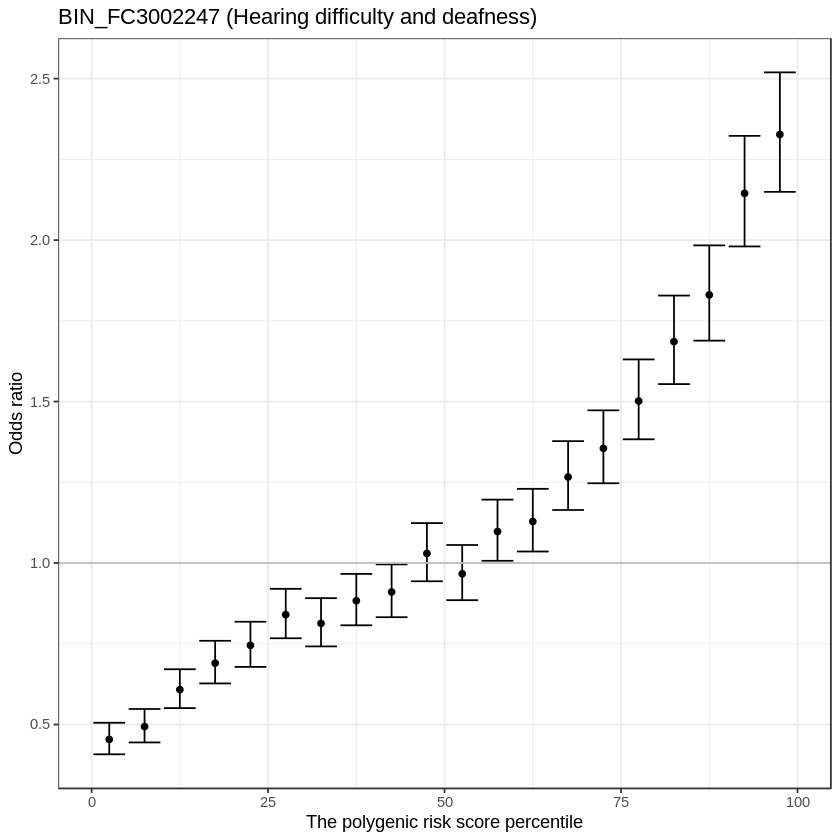

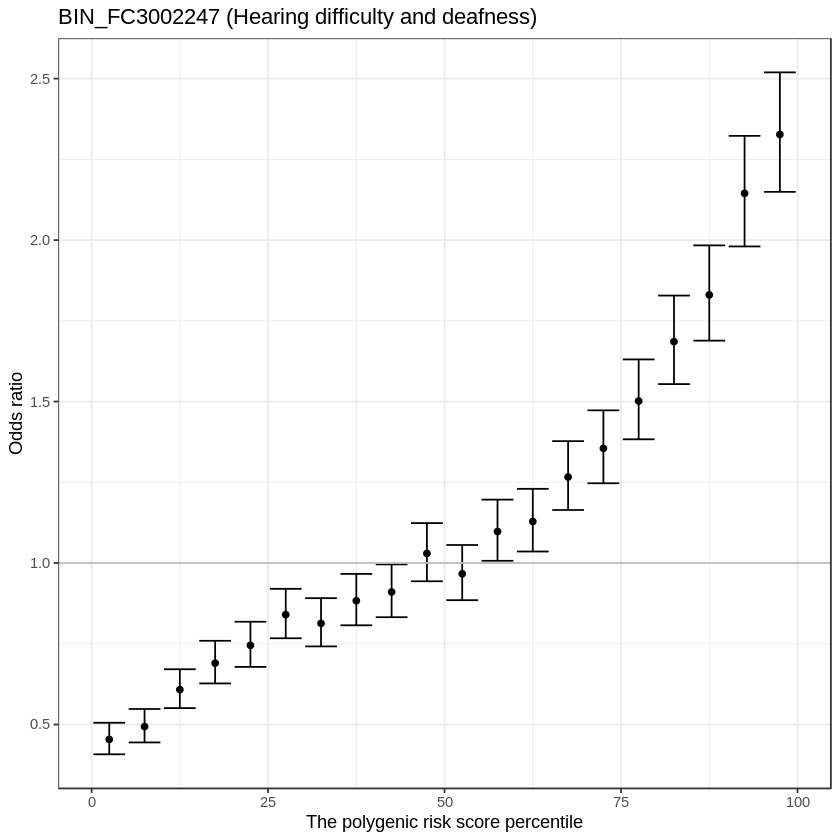

In [21]:
for(score in c('geno_score', 'covar_score', 'score')){
    print(score)
    compute_auc(all_df, 'test', score) %>% print()
}

OR_tbl <- all_df %>% compute_OR_tbl('test', 'score')

p <- OR_tbl %>%
filter(u_bin != 0.001, u_bin != 0.01, l_bin != 0.99, l_bin != 0.999) %>%
mutate(bin = 100 * (1 - 0.5 * (u_bin + l_bin))) %>%
ggplot(aes(x=bin, y=OR)) +
geom_point() + 
geom_errorbar(aes(ymin = l_OR, ymax = u_OR)) + 
geom_hline(yintercept = 1, color='gray')+
theme_bw() + 
labs(
    title = sprintf('%s (%s)', GBE_ID, phe_label),
    x = 'The polygenic risk score percentile',
    y = 'Odds ratio'
)

OR_tbl %>% fwrite(paste0(GBE_ID, '.OR.tsv'), sep='\t')

p + ggsave(paste0(GBE_ID, '.OR.pdf'))
p + ggsave(paste0(GBE_ID, '.OR.png'))


In [22]:
OR_tbl

l_bin,u_bin,n_TP,n_FN,n_FP,n_TN,OR,SE_LOR,l_OR,u_OR,OR_str
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
0.000,0.050,1462,3363,1796,9614,2.3271174,0.04052352,2.1494333,2.5194898,2.327 (2.149-2.519)
0.050,0.100,1397,3363,1862,9614,2.1448355,0.04067241,1.9804912,2.3228172,2.145 (1.980-2.323)
0.100,0.150,1276,3363,1993,9614,1.8302930,0.04107096,1.6887304,1.9837226,1.830 (1.689-1.984)
0.150,0.200,1207,3363,2047,9614,1.6856472,0.04145345,1.5541065,1.8283215,1.686 (1.554-1.828)
0.200,0.250,1121,3363,2134,9614,1.5017182,0.04197657,1.3831117,1.6304956,1.502 (1.383-1.630)
0.250,0.300,1051,3363,2217,9614,1.3552340,0.04247238,1.2469845,1.4728804,1.355 (1.247-1.473)
0.300,0.350,1002,3363,2262,9614,1.2663460,0.04291223,1.1641924,1.3774632,1.266 (1.164-1.377)
0.350,0.400,919,3363,2328,9614,1.1285214,0.04380709,1.0356677,1.2296999,1.129 (1.036-1.230)
0.400,0.450,903,3363,2352,9614,1.0975585,0.04397679,1.0069175,1.1963589,1.098 (1.007-1.196)
